In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV


#### Reading data into Pandas Dataframe

In [2]:
file_name = 'car_data.csv'
df = pd.read_csv(file_name, skipinitialspace = True)

### Data Preprocessing

In [3]:
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.shape

(301, 9)

In [6]:
df[df.duplicated()]

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
17,ertiga,2016,7.75,10.79,43000,Diesel,Dealer,Manual,0
93,fortuner,2015,23.00,30.61,40000,Diesel,Dealer,Automatic,0


In [7]:
# Dropping duplicate recrods from the dataframe
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(299, 9)

In [9]:
#Checking for null values
df.isnull().any()  # No missing values found. Data is complete

Car_Name         False
Year             False
Selling_Price    False
Present_Price    False
Kms_Driven       False
Fuel_Type        False
Seller_Type      False
Transmission     False
Owner            False
dtype: bool

### Exploratory Data Analysis

#### 1. Data distribution across years (Histogram for Year in which the vehicle was bought)
##### Observation: Most of the data is available from 2010 to 2018  (left skewed or negatively skewed)

Text(0, 0.5, 'Number Of vehicles bought')

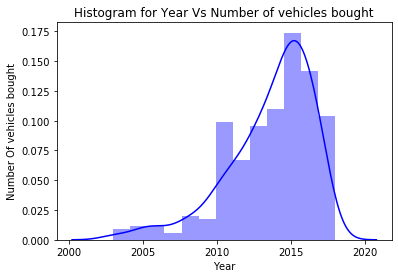

In [10]:
sns.distplot(df['Year'], kde=True, color='blue')
plt.title('Histogram for Year Vs Number of vehicles bought', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number Of vehicles bought', fontsize=10)

#### 2. Selling Price Vs Number of vehicles sold  (Histogram for Selling Price)
##### Observation: 30% of the sold vehicles are within the range of 0.1 to 2 Lakhs  (Right skewed)

Text(0, 0.5, 'Number Of vehicles bought')

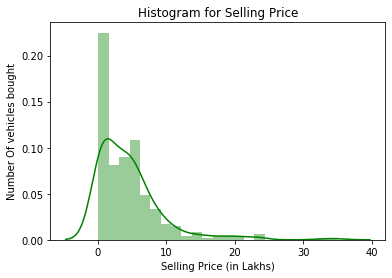

In [11]:
sns.distplot(df['Selling_Price'], kde=True, color='green')
plt.title('Histogram for Selling Price', fontsize=12)
plt.xlabel('Selling Price (in Lakhs)', fontsize=10)
plt.ylabel('Number Of vehicles bought', fontsize=10)

#### 3. Present Price Vs Number of vehicles sold  (Histogram for Showroom/Present Price)
##### Observation: 30% of the sold vehicles are within the range of 0.3 to 2 Lakhs  (Right skewed)

Text(0, 0.5, 'Number Of vehicles bought')

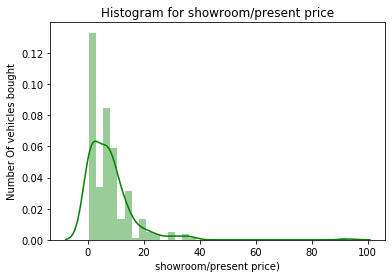

In [12]:
#Histogram for showroom/present price
sns.distplot(df['Present_Price'], kde=True, color='green')
plt.title('Histogram for showroom/present price', fontsize=12)
plt.xlabel('showroom/present price)', fontsize=10)
plt.ylabel('Number Of vehicles bought', fontsize=10)
# plt.ticklabel_format(style='sci', axis='Present_Price')
# plt.show()

#### 4. Number of vehicles sold via Dealer Vs Individual
##### Observation: 60% of the sales are done through Dealers

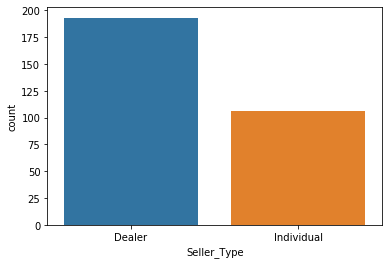

In [13]:
# For all petrol,diesel and cng vehicle types the dealer seller count is more than Individual
sns.countplot(x='Seller_Type',data=df)

#### 5. Transmission type VS Number of Cars sold
##### Observation: Demand is more for Manual transmission vehicles 

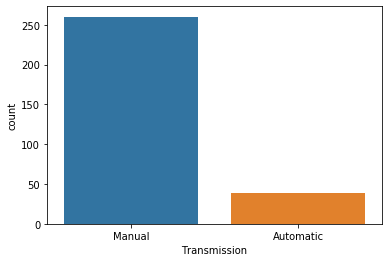

In [14]:
sns.countplot(x='Transmission',data=df)

#### 6. Price range across different trasmission types

##### The number of Automatic transmission vehicles sold are uniformly distributed across the selling price range 0.3 to 23 Lakhs.
##### Whereas in Manual type, most of the sales are within the range of <15 Lakhs. The reason being all bikes are manual and therefore the selling price is more on the lower range.

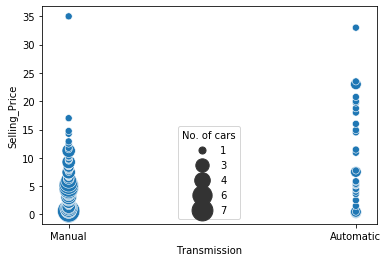

In [15]:
plt_df = df.groupby(['Selling_Price', 'Transmission']).size().to_frame(name="No. of cars").reset_index()
# sns.scatterplot(y='Selling_Price',x='Transmission',hue='Transmission', data=df)
sns.scatterplot(y='Selling_Price',x='Transmission', size='No. of cars', sizes = (50,500)
                 ,data=plt_df)

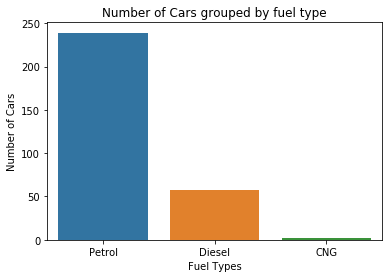

In [16]:
# Number of cars grouped by fuel type
sns.countplot(data=df,x="Fuel_Type")
plt.title('Number of Cars grouped by fuel type')
plt.ylabel('Number of Cars')
plt.xlabel('Fuel Types')
plt.show()

#### 7. Number distinct vehicle names available in the dataset
##### Observation: We have 98 distinct vehicle names and name of companies won’t affect car’s price. Price depends upon how many year it’s been used ,fuel type etc,.

In [17]:
len(df["Car_Name"].unique())

98

In [18]:
df.drop('Car_Name', inplace= True, axis=1)
print("Car_Name feature is dropped from the dataset")

Car_Name feature is dropped from the dataset


### Feature Engineering

In [19]:
# Dividing the features into Numerical and Categorical

numericaldata = df.select_dtypes(include=['number']).columns.tolist()
categoricaldata = df.select_dtypes(include=['object']).columns.tolist()

#### FE1 - One Hot Encoding the Categorical features

In [20]:
# Converting categorical features to numerical
ohe_df = pd.get_dummies(df, columns=categoricaldata, drop_first=True, sparse=True)
df.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [21]:
ohe_df.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,2014,3.35,5.59,27000,0,0,1,0,1
1,2013,4.75,9.54,43000,0,1,0,0,1
2,2017,7.25,9.85,6900,0,0,1,0,1
3,2011,2.85,4.15,5200,0,0,1,0,1
4,2014,4.60,6.87,42450,0,1,0,0,1


#### FE2 - Creating a new Feature called age_of_car

In [22]:
# Feature Engineering - Creating a new Feature called age_of_car
aoc_df = ohe_df
aoc_df['current_year']='2021'
aoc_df['current_year'] = aoc_df['current_year'].astype(int)
aoc_df['age_of_car']=aoc_df['current_year'] - aoc_df['Year']

In [23]:
aoc_df.head(5)

,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,current_year,age_of_car
0,2014,3.35,5.59,27000,0,0,1,0,1,2021,7
1,2013,4.75,9.54,43000,0,1,0,0,1,2021,8
2,2017,7.25,9.85,6900,0,0,1,0,1,2021,4
3,2011,2.85,4.15,5200,0,0,1,0,1,2021,10
4,2014,4.60,6.87,42450,0,1,0,0,1,2021,7


In [24]:
#Dropping the Year and Current Year as no longer required
aoc_df.drop(['Year','current_year'],inplace=True, axis=1)

In [25]:
aoc_df.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,age_of_car
0,3.35,5.59,27000,0,0,1,0,1,7
1,4.75,9.54,43000,0,1,0,0,1,8
2,7.25,9.85,6900,0,0,1,0,1,4
3,2.85,4.15,5200,0,0,1,0,1,10
4,4.60,6.87,42450,0,1,0,0,1,7


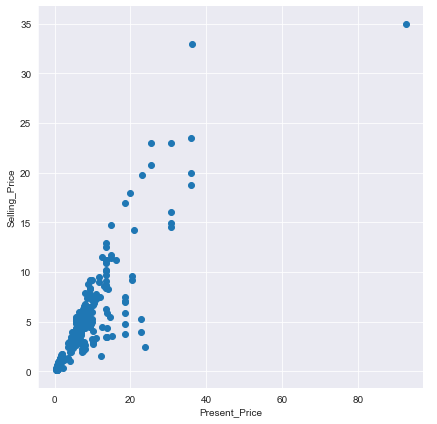

In [26]:
sns.set_style("darkgrid")
sns.FacetGrid(aoc_df,height=6).map(plt.scatter,"Present_Price","Selling_Price").add_legend()
plt.show()

# We can see linear relationship between Selling_Price and Present_Price

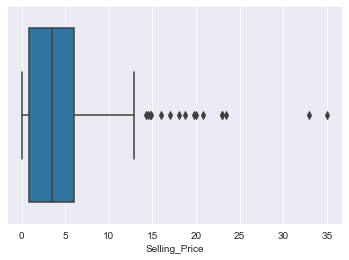

In [27]:
sns.boxplot(x=aoc_df['Selling_Price'])

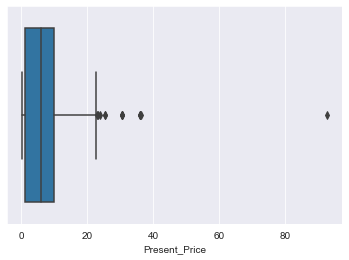

In [28]:
sns.boxplot(x=aoc_df['Present_Price'])

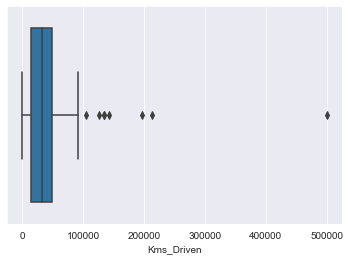

In [29]:
sns.boxplot(x=aoc_df['Kms_Driven'])

#### Dropping the outliers from the dataset

In [30]:
aoc_df.shape

(299, 9)

In [31]:
aoc_df = aoc_df[aoc_df.Selling_Price < 30]
aoc_df = aoc_df[aoc_df.Present_Price < 30]
aoc_df = aoc_df[aoc_df.Kms_Driven < 250000]
aoc_df.shape

(289, 9)

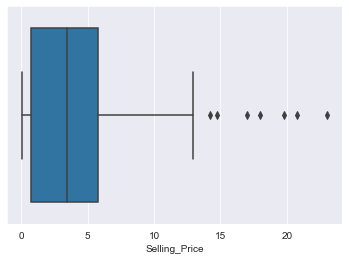

In [32]:
sns.boxplot(x=aoc_df['Selling_Price'])

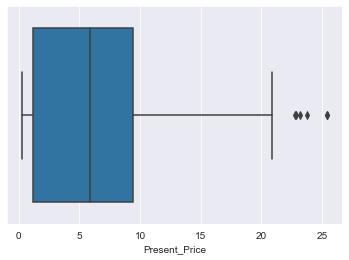

In [33]:
sns.boxplot(x=aoc_df['Present_Price'])

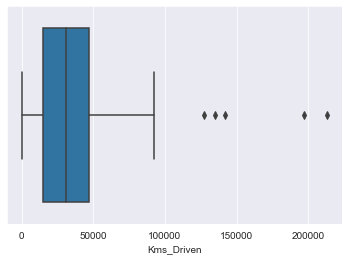

In [34]:
sns.boxplot(x=aoc_df['Kms_Driven'])

#### 8. Distance Travelled vs Demand
##### Observation: More than 90% of the vehicles bought are driven less than 100,000 Km

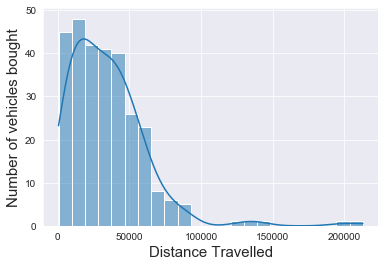

In [35]:
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.histplot(aoc_df['Kms_Driven'], kde = True)
# sns.distplot(df['Kms_Driven'], kde=True, color='green')
plt.xlabel("Distance Travelled",Fontsize=15)
plt.ylabel("Number of vehicles bought",Fontsize=15)
plt.show()

#### Feature Selection

#### 1. Filter Method (Using Correlation Coefficient)

##### Observations:
##### i) Present_Price and Selling_Price are positively correlated
##### ii)  Fuel_Type_Petrol and Fuel_Type_Diesel seem to similar, So we can exclude one of them from dataframe

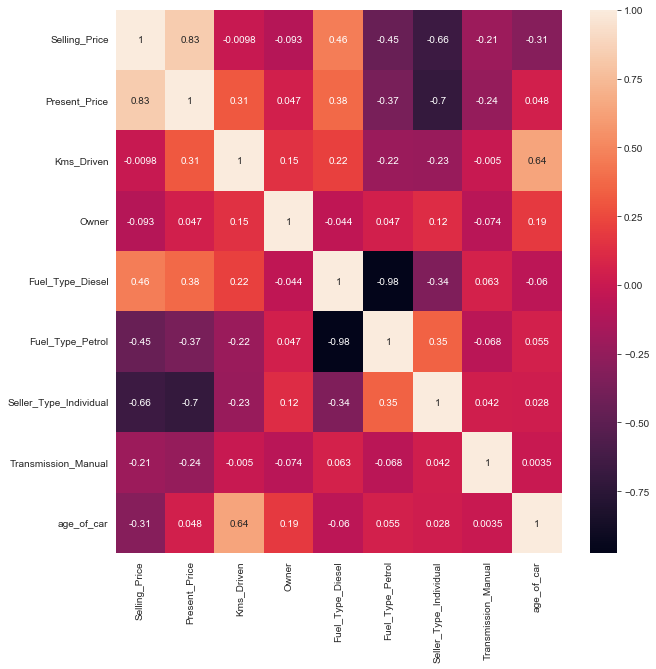

In [36]:
corr = aoc_df.corr()
corr_features = corr.index
plt.figure(figsize=(10,10))
g = sns.heatmap(aoc_df[corr_features].corr(), annot=True)

In [37]:
aoc_df.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,age_of_car
0,3.35,5.59,27000,0,0,1,0,1,7
1,4.75,9.54,43000,0,1,0,0,1,8
2,7.25,9.85,6900,0,0,1,0,1,4
3,2.85,4.15,5200,0,0,1,0,1,10
4,4.60,6.87,42450,0,1,0,0,1,7


In [38]:
#Dropping the Year and Current Year as no longer required
excl_ftp_df = aoc_df.drop(['Fuel_Type_Petrol'], axis=1)
excl_ftp_df.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,age_of_car
0,3.35,5.59,27000,0,0,0,1,7
1,4.75,9.54,43000,0,1,0,1,8
2,7.25,9.85,6900,0,0,0,1,4
3,2.85,4.15,5200,0,0,0,1,10
4,4.60,6.87,42450,0,1,0,1,7


In [39]:
X = excl_ftp_df.iloc[:,1:9]
y = excl_ftp_df.iloc[:,0:1]
# print(X)
# print(y)

#### 2. Using Tree Classifier

##### Observation: Present_Price has the highest importance in predicting the target variable Selling Price, whereas the number of previous owners has less significance.


[0.39942789 0.04789238 0.00058856 0.02749883 0.35484082 0.02233385
 0.14741766]


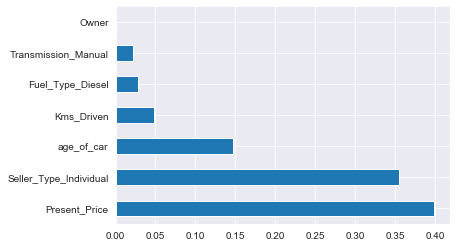

In [40]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)
print(model.feature_importances_)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns) 
feat_importances.nlargest(9).plot(kind='barh')
plt.show()

In [41]:
excl_ftp_df.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,age_of_car
0,3.35,5.59,27000,0,0,0,1,7
1,4.75,9.54,43000,0,1,0,1,8
2,7.25,9.85,6900,0,0,0,1,4
3,2.85,4.15,5200,0,0,0,1,10
4,4.60,6.87,42450,0,1,0,1,7


In [42]:
#Dropping the Year and Current Year as no longer required
excl_owner_df = excl_ftp_df.drop(['Owner'], axis=1)
excl_owner_df.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,age_of_car
0,3.35,5.59,27000,0,0,1,7
1,4.75,9.54,43000,1,0,1,8
2,7.25,9.85,6900,0,0,1,4
3,2.85,4.15,5200,0,0,1,10
4,4.60,6.87,42450,1,0,1,7


### Standardizing the features

In [43]:
#### Standardizing the features
def StandardizeFeatures(df):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler() 
    scaled_data = scaler.fit_transform(df)
    std_df = pd.DataFrame(scaled_data)
#     new_df.head()
    return std_df

### Comparing the feature selection techniques

### Defining the Model

### 1. Random Forest Regressor

#### High Level Description Of Random Forest
A random forest is a machine learning technique that’s used to solve regression and classification 
problems. It utilizes ensemble learning, which is a technique that combines many classifiers to 
provide solutions to complex problems.
The (random forest) algorithm establishes the outcome based on the predictions of the decision trees. 
It predicts by taking the average or mean of the output from various trees. 
Increasing the number of trees increases the precision of the outcome.
A random forest eradicates the limitations of a decision tree algorithm. It reduces the overfitting 
of datasets and increases precision

In [44]:
#Random Forest Model
def rfr(x_train,x_test,y_train,y_test,random_grid):
    from sklearn.metrics import r2_score
    Rf = RandomForestRegressor(n_estimators = random_grid['n_estimators']
                               , max_features = random_grid['max_features']
                               , max_depth = random_grid['max_depth']
                               , min_samples_split = random_grid['min_samples_split']
                               ,min_samples_leaf = random_grid['min_samples_leaf']
                               , random_state=25, n_jobs = 1)
                               
    Rf.fit(x_train,y_train)
    Rf_train_pred = Rf.predict(x_train)
    Rf_test_pred = Rf.predict(x_test)
    
    rfm_r2score = round(r2_score(y_test,Rf_test_pred),4)*100
    
    return Rf_train_pred,Rf_test_pred,rfm_r2score


### 2. Linear Regression

#### High Level Description Of Linear Regression
Linear regression is a linear model that assumes a linear relationship between the input variables (x) and the single output variable (y). More specifically, that y can be calculated from a linear combination of the input variables (x).

In [45]:
#Linear Regression Model
def LinReg(x_train,x_test,y_train,y_test):
    from sklearn.linear_model import LinearRegression
    lreg = LinearRegression()
    lreg.fit(x_train,y_train)
    y_train_pred = lreg.predict(x_train)
    y_test_pred = lreg.predict(x_test)
    lreg_score = round(lreg.score(x_test,y_test),4)*100
    
    return y_train_pred,y_test_pred,lreg_score

In [46]:
#### Standardizing the features
std_ohe_df_fe1 = StandardizeFeatures(excl_ftp_df)
std_ohe_df_fe1.head()

,0,1,2,3,4,5,6,7
0,-0.188599,-0.173969,-0.267973,-0.178199,-0.451848,-0.749775,0.340338,-0.125171
1,0.183014,0.536337,0.317505,-0.178199,2.213133,-0.749775,0.340338,0.219347
2,0.846609,0.592082,-1.003479,-0.178199,-0.451848,-0.749775,0.340338,-1.158727
3,-0.321317,-0.432916,-1.065686,-0.178199,-0.451848,-0.749775,0.340338,0.908385
4,0.143199,0.056206,0.297379,-0.178199,2.213133,-0.749775,0.340338,-0.125171


In [47]:
X = std_ohe_df_fe1.iloc[:,1:9]
y = std_ohe_df_fe1.iloc[:,0:1]
# print(X)
# print(y)

### Random Forest Regressor with FE1

In [48]:
# Splitting the dataset into test and train
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 10)

In [49]:
#### Hyper parameter tuning - code to find best parameters for Random Forest Regressor

In [50]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [51]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# print(random_grid)

In [52]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid
                               ,scoring='neg_mean_squared_error', n_iter = 10, cv = 5
                               , verbose=2, random_state=25, n_jobs = 1)
rf_random.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   0.6s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   0.6s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   0.6s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   0.6s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   0.6s
[CV] n_estimators=700, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   0.8s
[CV] n_estimators=700, min_samples_split=5, min

[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   1.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   1.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   1.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   1.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   1.1s
[CV] n_estimators=500, min_samples_split=2,

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   40.1s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [53]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 25}

In [54]:
random_grid = rf_random.best_params_
print(random_grid)

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 25}


In [55]:
rf_train_pred, rf_test_pred, rf_r2score = rfr(x_train,x_test,y_train,y_test,random_grid)

In [56]:
# calculate MAE, MSE, RMSE

print('=================================')
print('Random Forest Regressor with FE1')
print('=================================')
print('R2 Score: %2.2f%%' %(rf_r2score))
print('Mean Absolute Error: %2.2f' %(metrics.mean_absolute_error(y_test, rf_test_pred)))
print('Mean Squared Error: %2.2f' %(metrics.mean_squared_error(y_test, rf_test_pred)))
print('Root Mean Squared Error: %2.2f' %(np.sqrt(metrics.mean_squared_error(y_test, rf_test_pred))))

Random Forest Regressor with FE1
R2 Score: 96.04%
Mean Absolute Error: 0.11
Mean Squared Error: 0.03
Root Mean Squared Error: 0.18


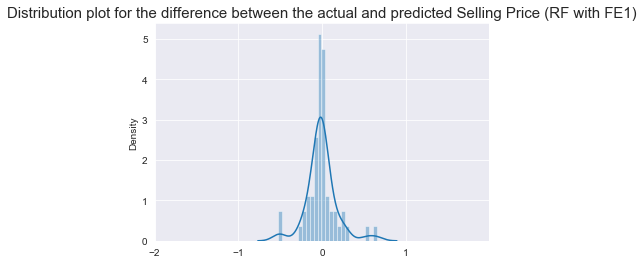

In [57]:
rf_pred = rf_test_pred.reshape(58,1)
# sns.set(rc = {'figure.figsize':(6,6)})
fig, ax = plt.subplots()
sns.distplot(y_test-rf_pred, ax=ax)
ax.set_xlim(-2,2)
ax.set_xticks(range(-2,2))
plt.title("Distribution plot for the difference between the actual and predicted Selling Price (RF with FE1)",Fontsize=15)
plt.show()

### Linear Regression with FE1

In [58]:
lr_train_pred, lr_test_pred, lr_r2score = LinReg(x_train,x_test,y_train,y_test)

In [59]:
# calculate MAE, MSE, RMSE
print('===========================')
print('Linear Regression with FE1')
print('==========================')
print('R2 Score: %2.2f%%' %(lr_r2score))
print('Mean Absolute Error: %2.2f' %(metrics.mean_absolute_error(y_test, lr_test_pred)))
print('Mean Squared Error: %2.2f' %(metrics.mean_squared_error(y_test, lr_test_pred)))
print('Root Mean Squared Error: %2.2f' %(np.sqrt(metrics.mean_squared_error(y_test, lr_test_pred))))

Linear Regression with FE1
R2 Score: 74.59%
Mean Absolute Error: 0.33
Mean Squared Error: 0.21
Root Mean Squared Error: 0.46


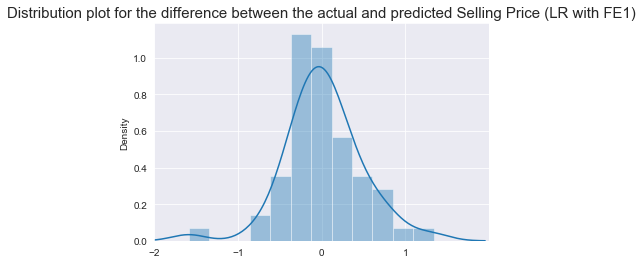

In [60]:
lr_pred = lr_test_pred.reshape(58,1)
fig, ax = plt.subplots()
sns.distplot(y_test-lr_pred, ax=ax)
ax.set_xlim(-2,2)
ax.set_xticks(range(-2,2))
plt.title("Distribution plot for the difference between the actual and predicted Selling Price (LR with FE1)",Fontsize=15)
plt.show()

In [61]:
std_aoc_df_fe2 = StandardizeFeatures(excl_owner_df)

In [62]:
X = std_aoc_df_fe2.iloc[:,1:9]
y = std_aoc_df_fe2.iloc[:,0:1]
# print(X)
# print(y)

### Random Forest Regressor with FE2

In [63]:
# Splitting the dataset into test and train
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 10)

In [64]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# print(random_grid)

In [65]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid
                               ,scoring='neg_mean_squared_error', n_iter = 10, cv = 5
                               , verbose=2, random_state=25, n_jobs = 1)
rf_random.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   0.6s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   0.6s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   0.6s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   0.6s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   0.6s
[CV] n_estimators=700, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   0.8s
[CV] n_estimators=700, min_samples_split=5, min

[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   1.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   1.1s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   1.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   1.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=15, total=   1.3s
[CV] n_estimators=500, min_samples_split=2,

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   39.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [66]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 5}

In [67]:
random_grid = rf_random.best_params_
print(random_grid)

{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}


In [68]:
rf_train_pred, rf_test_pred, rf_r2score = rfr(x_train,x_test,y_train,y_test,random_grid)


In [69]:
# calculate MAE, MSE, RMSE
print('=================================')
print('Random Forest Regressor with FE2')
print('=================================')
print('R2 Score: %2.2f%%' %(rf_r2score))
print('Mean Absolute Error: %2.2f' %(metrics.mean_absolute_error(y_test, rf_test_pred)))
print('Mean Squared Error: %2.2f' %(metrics.mean_squared_error(y_test, rf_test_pred)))
print('Root Mean Squared Error: %2.2f' %(np.sqrt(metrics.mean_squared_error(y_test, rf_test_pred))))

Random Forest Regressor with FE2
R2 Score: 91.64%
Mean Absolute Error: 0.18
Mean Squared Error: 0.07
Root Mean Squared Error: 0.26


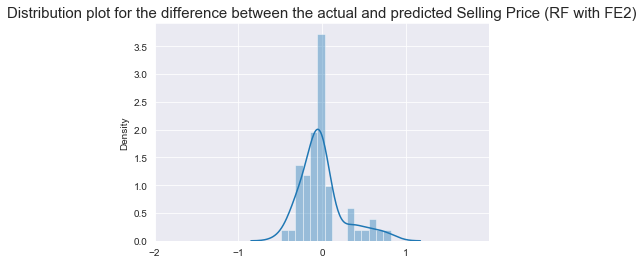

In [70]:
rf_pred = rf_test_pred.reshape(58,1)
fig, ax = plt.subplots()
sns.distplot(y_test-rf_pred, ax=ax)
ax.set_xlim(-2,2)
ax.set_xticks(range(-2,2))
plt.title("Distribution plot for the difference between the actual and predicted Selling Price (RF with FE2)",Fontsize=15)
plt.show()

### Linear Regression with FE2

In [71]:
lr_train_pred, lr_test_pred, lr_r2score = LinReg(x_train,x_test,y_train,y_test)

In [72]:
# calculate MAE, MSE, RMSE
print('===========================')
print('Linear Regression with FE2')
print('==========================')
print('R2 Score: %2.2f%%' %(lr_r2score))
print('Mean Absolute Error: %2.2f' %(metrics.mean_absolute_error(y_test, lr_test_pred)))
print('Mean Squared Error: %2.2f' %(metrics.mean_squared_error(y_test, lr_test_pred)))
print('Root Mean Squared Error: %2.2f' %(np.sqrt(metrics.mean_squared_error(y_test, lr_test_pred))))

Linear Regression with FE2
R2 Score: 75.68%
Mean Absolute Error: 0.32
Mean Squared Error: 0.20
Root Mean Squared Error: 0.45


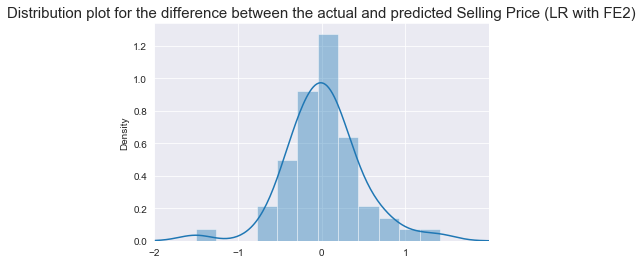

In [73]:
lr_pred = lr_test_pred.reshape(58,1)
fig, ax = plt.subplots()
sns.distplot(y_test-lr_pred, ax=ax)
ax.set_xlim(-2,2)
ax.set_xticks(range(-2,2))
plt.title("Distribution plot for the difference between the actual and predicted Selling Price (LR with FE2)",Fontsize=15)
plt.show()

### Conclusion

#### From the above results, it is observed that the Random Forest ML Technique with feature ranking technique 1 (heat map) gives the best result. The accuracy for this combination is the highest among the four and the Root Mean Squared Error is the Lowest.

In [74]:
# import pickle
# pickle.dump(model,open("model.pkl","wb"),protocol=2)